In [1]:
import sys
sys.path.append('../')
import _init_paths

In [2]:
import time
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pip.utils import ensure_dir

import _init_paths

import cPickle
import numpy as np
from six.moves import xrange

import logging
import tensorflow as tf
from tensorflow.python.platform import flags

from cleverhans.utils_mnist import data_mnist
from cleverhans.utils import to_categorical
from cleverhans.utils import set_log_level
from cleverhans.utils_tf import model_train
from cleverhans.attacks import FastGradientMethod
from cleverhans.attacks_tf import jacobian_graph, jacobian_augmentation

from models.gan import MnistGAN, CifarGAN, FmnistGAN, CelebaGAN
from utils.config import load_config
from utils.gan_defense import model_eval_gan
from utils.network_builder import model_a, model_b, model_c, model_d, model_e, model_f, model_z
from utils.visualize import save_images_files
import keras.backend as K
from sklearn.neighbors import KNeighborsClassifier

import math
from cleverhans.utils import batch_indices, _ArgsWrapper, create_logger, set_log_level

import os
from datasets.celeba import CelebA
from datasets.dataset import PickleLazyDataset
from defense import get_train_test

FLAGS = flags.FLAGS
ds_gan = {'mnist': MnistGAN, 'cifar': CifarGAN, 'f-mnist': FmnistGAN, 'celeba' : CelebaGAN, 'celeba_wider' : CelebaGAN}
orig_data_paths = {k: 'data/cache/{}_pkl'.format(k) for k in ds_gan.keys()}


Using TensorFlow backend.
../tflib/plot.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib64/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib64/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/scratch0/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/scratch0/pyenv/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/scratch0/pyenv/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/scratch0/pyenv/lib/pyt

In [3]:
vectorize = lambda x : x.reshape([x.shape[0],-1])
def inv_onehot(ys):
    assert len(np.shape(ys)) > 1
    return np.argmax(ys,axis=1)

def convert_to_onehot(ys):
    max_y = int(np.max(ys))
    y_one_hat = np.zeros([len(ys), max_y + 1], np.float32)
    for (i, y) in enumerate(ys):
        y_one_hat[i, int(y)] = 1.0
    return y_one_hat

In [4]:
from datasets.mnist import Mnist

In [6]:
ds_train = Mnist()
_ = ds_train.load()
ds_val = Mnist()
_ = ds_val.load()

In [7]:
print(ds_train.X.shape)
ds_train.X = ds_train.X / 255.0
ds_val.X = ds_val.X / 255.0
print('[#] Max: {}, Min: {}'.format(ds_train.X.max(),ds_train.X.min()))

(50000, 28, 28, 1)
[#] Max: 1.0, Min: 0.0


In [8]:
num_train = 20000
num_tests = 2000
vectorize = lambda x : x.reshape([x.shape[0],-1])

X_train, Y_train, X_test, Y_test = [vectorize(ds_train.X[:num_train]), ds_train.y[:num_train], vectorize(ds_val.X[:num_tests]), ds_val.y[:num_tests]]

[*] Label : 0.0


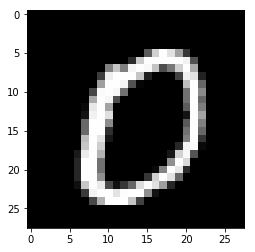

In [9]:
test_id = 0
Y_plt = Y_test[test_id]
X_plt = X_test[test_id]
plt.imshow(X_plt.reshape((28,28))*255.0,cmap='gray')
print('[*] Label : {}'.format(Y_plt))

In [10]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train,Y_train)
y_t = model.predict(vectorize(X_test))
accuracy = np.mean(y_t == Y_test)
print(Y_test)
print(y_t)
print(accuracy)
#knn_model = prep_bbox(X_train,Y_train,X_test,Y_test)

[ 0.  5.  9. ...,  9.  2.  3.]
[ 0.  5.  9. ...,  9.  2.  3.]
0.977


In [11]:
sub_model_letter = 'B'
holdout = 150

x_shape, classes = list(X_train.shape[1:]), 10
models = {'A': model_a, 'B': model_b, 'C': model_c, 'D': model_d, 'E': model_e, 'F': model_f,
              'Z': model_z}

x_shape = [28,28,1]
x = tf.placeholder(tf.float32, shape=[None] + x_shape)
y = tf.placeholder(tf.float32, shape=(None, classes))

def to_mnist_shape(XX):
    return XX.reshape([XX.shape[0],28,28,1])

Y_test_ = convert_to_onehot(Y_test)
Y_train_ = convert_to_onehot(Y_train)

X_sub = X_test[:holdout]
Y_sub = Y_test[:holdout]
Y_sub_ = Y_test_[:holdout]
X_test = X_test[holdout:]
Y_test = Y_test[holdout:]

sub_model = models[sub_model_letter](input_shape = [None]+ x_shape,nb_classes = classes)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [12]:
vectorize = lambda x : x.reshape([x.shape[0],-1])
def inv_onehot(ys):
    assert len(np.shape(ys)) > 1
    return np.argmax(ys,axis=1)

def convert_to_onehot(ys):
    max_y = int(np.max(ys))
    y_one_hat = np.zeros([len(ys), max_y + 1], np.float32)
    for (i, y) in enumerate(ys):
        y_one_hat[i, int(y)] = 1.0
    return y_one_hat

In [13]:
print session

In [14]:

def model_eval(sess, x, y,x_adv, model, X_test=None, Y_test=None,
               feed=None, args=None,debug=False):
    """
    Compute the accuracy of a TF model on some data
    :param sess: TF session to use when training the graph
    :param x: input placeholder
    :param y: output placeholder (for labels)
    :param predictions: model output predictions
    :param X_test: numpy array with training inputs
    :param Y_test: numpy array with training outputs
    :param feed: An optional dictionary that is appended to the feeding
             dictionary before the session runs. Can be used to feed
             the learning phase of a Keras model for instance.
    :param args: dict or argparse `Namespace` object.
                 Should contain `batch_size`
    :param model: (deprecated) if not None, holds model output predictions
    :return: a float with the accuracy value
    """
    args = _ArgsWrapper(args or {})
    
    accuracy = 0.0
    
    nb_batches = int(math.ceil(float(len(X_test)) / args.batch_size))
    assert nb_batches * args.batch_size >= len(X_test)
    to_digit = lambda x : np.argmax(x,axis=1)
    for batch in range(nb_batches):
        start = batch * args.batch_size
        end = min(len(X_test), start + args.batch_size)
        cur_batch_size = end - start
        feed_dict = {x: X_test[start:end], y: Y_test[start:end]}
        if feed is not None:
            feed_dict.update(feed)
        cur_X_test = sess.run(x_adv,feed_dict=feed_dict)
        if debug:
            debug_dir = 'debug/knn'
            ensure_dir(debug_dir)
            save_images_files(cur_X_test, output_dir=debug_dir, postfix='adv')
            save_images_files(X_test[start:end], output_dir=debug_dir, postfix='orig')
            raise ValueException("DEBUG")

        cur_preds = model.predict(cur_X_test.reshape([cur_X_test.shape[0],-1]))
        cur_acc = np.mean(cur_preds == inv_onehot(Y_test[start:end]))
        accuracy += (cur_batch_size * cur_acc)

        sys.stdout.write('\r [-] Eval batch {}/{}: acc: {}'.format(batch,nb_batches,accuracy*1.0/((batch+1)*args.batch_size+1)))
        sys.stdout.flush()


    assert end >= len(X_test)

    # Divide by number of examples to get final value
    accuracy /= len(X_test)
    sys.stdout.write('\r [*] Done with testing \n')

    return accuracy

In [15]:
sess = session
knn_model = model
nb_classes = classes
data_aug = 6
rng = np.random.RandomState([2017, 8, 30])
model_sub = sub_model
preds_sub = model_sub(x)
lmbda = 0.1

X_sub = X_test[:holdout]
Y_sub = Y_test[:holdout]

# Define the Jacobian symbolically using TensorFlow
grads = jacobian_graph(preds_sub, x, nb_classes)

# Train the substitute and augment dataset alternatively
for rho in xrange(data_aug):
    train_params = {
        'nb_epochs': 10,
        'batch_size': 32,
        'learning_rate': 0.001
    }
    model_train(sess, x, y, preds_sub, to_mnist_shape(X_sub), convert_to_onehot(Y_sub),
                init_all=False, verbose=False, args=train_params,
                rng=rng, feed={K.learning_phase(): 1})

    # If we are not at last substitute training iteration, augment dataset
    if rho < data_aug - 1:
        print("Augmenting substitute training data.")
        # Perform the Jacobian augmentation
        X_sub = jacobian_augmentation(sess, x, to_mnist_shape(X_sub), Y_sub.astype(np.int), grads, lmbda, feed={K.learning_phase(): 0})

        print("Labeling substitute training data.")
        # Label the newly generated synthetic points using the black-box
        Y_sub = np.hstack([Y_sub, Y_sub])
        X_sub_prev = X_sub[int(len(X_sub) / 2):]
        yy = knn_model.predict(vectorize(X_sub_prev))
        Y_sub[int(len(X_sub) / 2):] = yy

../cleverhans/cleverhans/utils_tf.py:112: UserWarning: verbose argument is deprecated and will be removed on 2018-02-11. Instead, use utils.set_log_level(). For backward compatibility, log_level was set to logging.WARNING (30).
  warnings.warn("verbose argument is deprecated and will be removed"


 [*] Done with training 3
Augmenting substitute training data.
Labeling substitute training data.
 [*] Done with training 918
Augmenting substitute training data.
Labeling substitute training data.
 [*] Done with training 7357
Augmenting substitute training data.
Labeling substitute training data.
 [*] Done with training 5844
Augmenting substitute training data.
Labeling substitute training data.
 [*] Done with training 28444
Augmenting substitute training data.
Labeling substitute training data.
 [*] Done with training 83980917


In [16]:
eps = 0.3

fgsm_par = {'eps': eps, 'ord': np.inf, 'clip_min': 0., 'clip_max': 1.}
fgsm = FastGradientMethod(model_sub, sess=sess)

# Craft adversarial examples using the substitute
eval_params = {'batch_size': 32}
x_adv_sub = fgsm.generate(x, **fgsm_par)

diff = None

x_test = x_adv_sub
accuracy = model_eval(sess, x, y,x_adv_sub, model, to_mnist_shape(X_test), convert_to_onehot(Y_test),
        args=eval_params, feed={K.learning_phase(): 0},debug=False)
print('Test accuracy of oracle on adversarial examples generated '
          'using the substitute: ' + str(accuracy))

../cleverhans/cleverhans/attacks.py:39: UserWarning: CleverHans support for supplying a callable instead of an instance of the cleverhans.model.Model class is deprecated and will be dropped on 2018-01-11.
  warnings.warn("CleverHans support for supplying a callable"


 [*] Done with testing acc: 0.948842218632
Test accuracy of oracle on adversarial examples generated using the substitute: 0.952432432432


In [17]:

print('Test accuracy of oracle on adversarial examples generated '
          'using the substitute: ' + str(accuracy))

Test accuracy of oracle on adversarial examples generated using the substitute: 0.952432432432


In [18]:
print accuracy

0.95243243243243247